# **Dependancy**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
pip install deepxde

# **Model and PINN**

**This shows the equation**
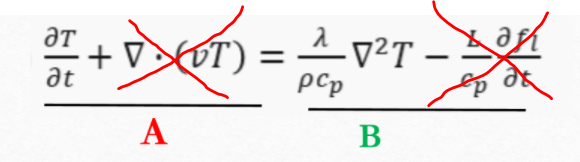

Compiling model...
Building feed-forward neural network...
'build' took 0.084627 s



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.697105 s

Initializing variables...
Training model...

0         [7.56e-02, 6.36e-01, 1.12e+00]    [7.47e-02, 0.00e+00, 0.00e+00]    [1.25e+00]    
1000      [5.11e-04, 8.26e-04, 5.17e-04]    [4.77e-04, 0.00e+00, 0.00e+00]    [5.71e-02]    
2000      [7.31e-05, 8.01e-04, 4.44e-04]    [7.75e-05, 0.00e+00, 0.00e+00]    [5.73e-02]    
3000      [4.64e-05, 6.90e-04, 3.82e-04]    [5.60e-05, 0.00e+00, 0.00e+00]    [6.22e-02]    
4000      [6.13e-05, 4.00e-04, 3.73e-04]    [1.43e-04, 0.00e+00, 0.00e+00]    [6.23e-02]    
5000      [6.04e-05, 2.93e-04, 3.27e-04]    [1.69e-04, 0.00e+00, 0.00e+00]    [6.70e-02]    
6000      [6.21e-05, 1.99e-04, 2.70e-04]    [2.51e-04, 0.00e+00, 0.00e+00]    [7.30e-02]    
7000      [6.18e-05, 1.06e-04, 2.06e-04]    [5.95e-04, 0.00e+00, 0.00e+00]    [8.05e-02]    
8000      [5.04e-05, 4.34e-05, 1.33e-04]    [8.87e-04, 0.00e+00, 0.00e+00]    [8.53e-02]    
9000      [3.21e-05, 2.42e-05, 6.51e-05]    [8.85e-04, 0.00e+00, 0.00e+00]    [8.93e-02]   

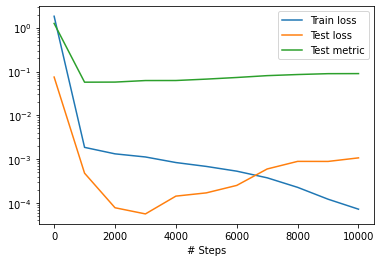

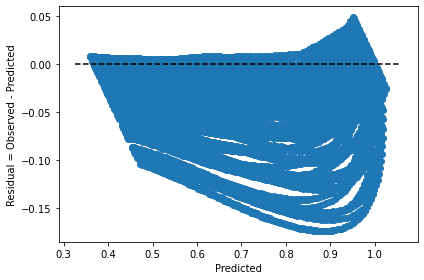

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

# y(the input to the function) represents T(temperature) here.
# dT_t = dT_yy + dT_zz
def pde(x, y):
    dT_t = dde.grad.jacobian(y, x, j=2)
    dT_yy = dde.grad.hessian(y, x, j=0)
    dT_zz = dde.grad.hessian(y, x, j=1)
    return (dT_t - (dT_yy + dT_zz))

def func(x): return np.exp(-x[:, 2:])

geom = dde.geometry.geometry_2d.Rectangle((0,0), (1,1))
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

layer_size = [3] + [32] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)


model = dde.Model(data, net)


model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)